## Customer segmentation project
CRISP-DM

Business understanding – What does the business need?
- Clustering of individual customers based on transactions metrics (count, price, recent transactions in time) 

Data understanding – What data do we have / need? Is it clean?
- We have transactions data that is clean.

Data preparation – How do we organize the data for modeling? We need:
- to log transform and standard scale numerical data
- to create derivative features, and various grouping of the transactions data 
- to cluster and further profile each cluster based on most common items purchased
- to tokenize item description data and use countvectorizer per cluster per country

Modeling – What modeling techniques should we apply?
- Unsupervised learning algorithms (Kmeans, DBSCAN)
- For scalability make sure to create pipelines for pre-processing and modeling of new customers

Evaluation – Which model best meets the business objectives?
- For Kmeans use best practices(elbow and silhouette plots), for DBSCAN use manual gridsearch with avg silhouette.

Deployment – How do stakeholders access the results?
- Interactive dashboards like geospatial plot and pie charts per cluster per country

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from itertools import product

import warnings
warnings.filterwarnings("ignore")
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

#### Import data and RFM

In [2]:
df = pd.read_csv("OnlineRetail.csv", encoding='unicode_escape').dropna().reset_index(drop=True)

In [3]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()  # sum of the money spend by ID

In [6]:
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency.head()  # customerID/unique trans

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: InvoiceNo, dtype: int64

In [7]:
# Rework recency (a lot days diff == recent == good)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['diff'] = df['InvoiceDate'] - min(df['InvoiceDate'])  # big days diff == recent == good
df['diff'] = df['diff'].dt.days   # recency 0days == 1
# df['diff'] = 1 / (1+df['diff'].dt.days)  # inspect this
recency = df.groupby('CustomerID')['diff'].max().reset_index()  # get max diff per customer
recency.head()  # most recent transaction of each cutomer

,CustomerID,diff
0,12346.0,48
1,12347.0,371
2,12348.0,298
3,12349.0,355
4,12350.0,63


In [8]:
## Create RFM

rfm = recency.merge(frequency, on='CustomerID').merge(monetary, on='CustomerID')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm[rfm < 0] = 0  # assign negative monetary to zero
rfm[rfm < 0].sum()
# we have monetary values that are negative which does not make sense and will produce nan in log transformation

CustomerID    0.0
Recency       0.0
Frequency     0.0
Monetary      0.0
dtype: float64

In [9]:
# Map customer per country in RFM

country_map = df[['CustomerID' ,'Country']].groupby('CustomerID').first()
rfm = rfm.merge(country_map, how='left', on='CustomerID')  # add countries

In [10]:
# Transform and scale RFM

from sklearn.preprocessing import StandardScaler
columns = ['Recency', 'Frequency', 'Monetary']
rfm_log = np.log1p(rfm[columns])  # transform
scaled_array = StandardScaler().fit_transform(rfm_log)  # scale
rfm_scaled = pd.DataFrame(scaled_array, columns=columns)

### Analysis and ML

#### Basic statistical analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


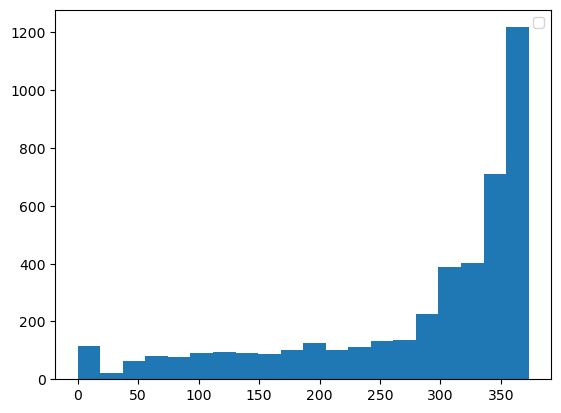

In [11]:
n_bins=20  #'fd'  # each bin can be interpret as cluster of customers
x = rfm.Recency
plt.hist(x, n_bins)
# plt.xticks(np.arange(-5, 5, step=1))
plt.legend(loc="upper right")
plt.show()

Notes:
- we have around 4000 unique customers
- distributions are different for each feature so find better way to present

The correlations between features explained:
- monetary = freq * amount
- recency = today - last transaction date
- frequency = all transactions count per customer

#### Machine learning analysis

Find most optimal ML algorithm in order to cluster customers by RFM features.

In [12]:
# %pip install yellowbrick -q

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(), k=(2, 9))

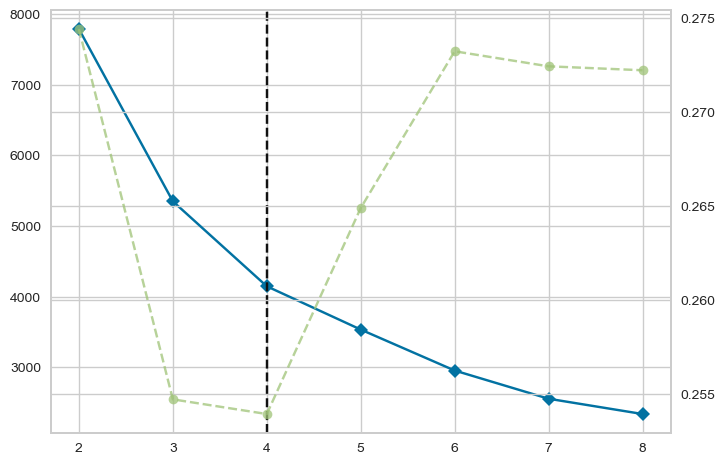

In [13]:
## Parameter search
from yellowbrick.cluster import KElbowVisualizer

elbow_visual = KElbowVisualizer(KMeans(), k=(2,9),
                                random_state=42)
elbow_visual.fit(rfm_scaled)

In [14]:
## Parameter search
from sklearn.metrics import silhouette_score
# Silhouette analysis
n_clusters = list(range(2,9))
for i in n_clusters:
    kmeans = KMeans(n_clusters=i, max_iter=50)
    kmeans.fit(rfm_scaled)

    cluster_labels = kmeans.labels_

    sil_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={}, the silhouette score is {}".format(i, sil_avg))

# This approach is not enough we need to visualize 

For n_clusters=2, the silhouette score is 0.402283420893405
For n_clusters=3, the silhouette score is 0.4170213779201409
For n_clusters=4, the silhouette score is 0.34646542716127815
For n_clusters=5, the silhouette score is 0.35805017304712367
For n_clusters=6, the silhouette score is 0.3583944127305895
For n_clusters=7, the silhouette score is 0.3228395561685606
For n_clusters=8, the silhouette score is 0.293736230664304


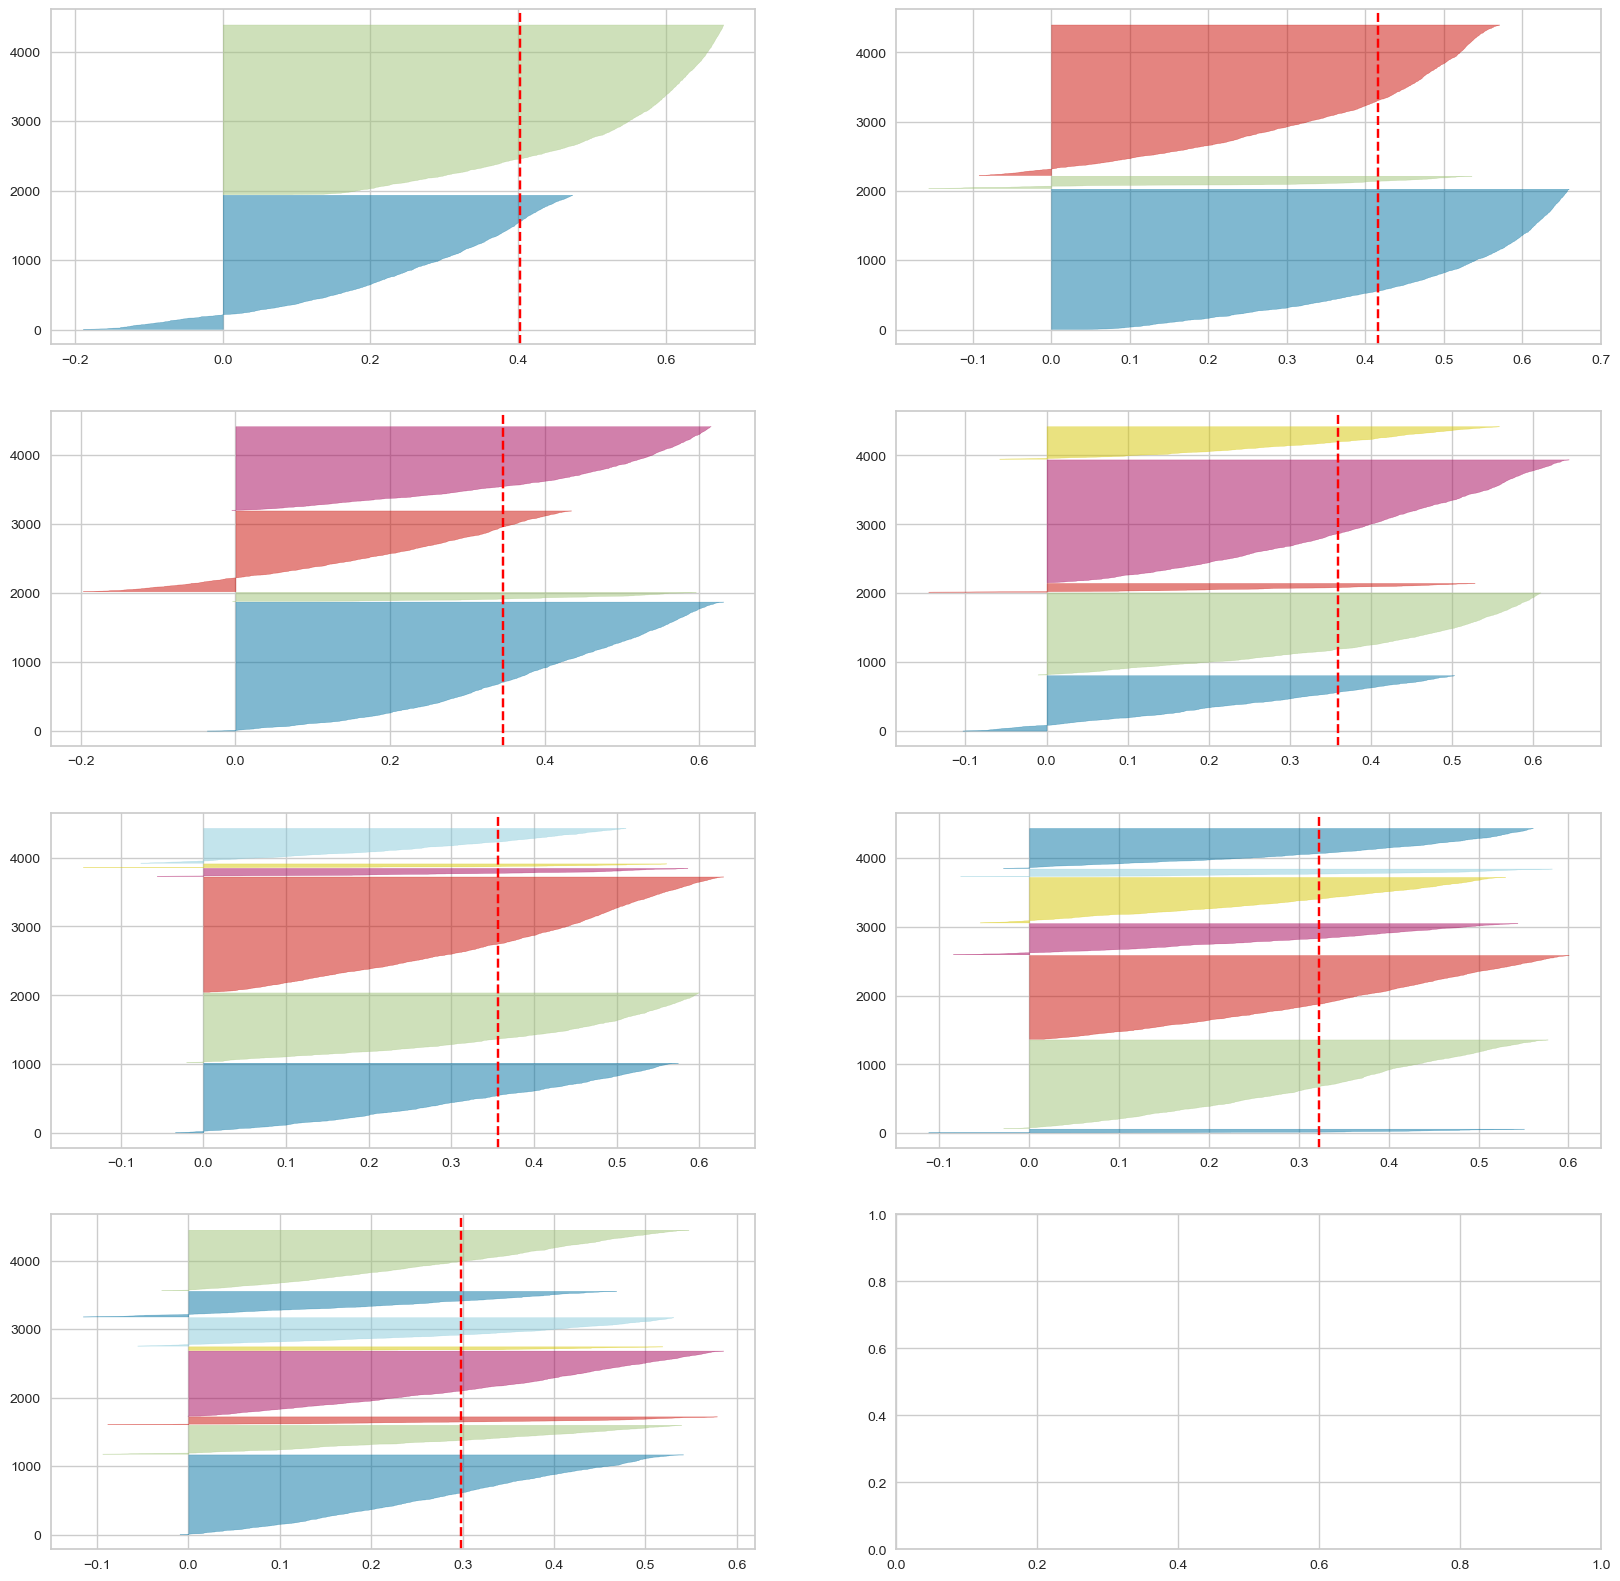

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(2,9):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', 
                n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_scaled)


In [16]:
# # Final fit (scaled data)
# km = KMeans(n_clusters=3, init='k-means++', 
#             n_init=10, max_iter=100, random_state=42)
# km.fit(rfm_scaled)

# # Concat labels
# rfm_scaled_plot = rfm_scaled.copy()
# rfm_scaled_plot['cluster'] = km.labels_
# # rfm['cluster'] = db.labels_

In [17]:
# DBSCAN parameter search
eps_list = np.linspace(0.1, 0.9, 5)
samples_list = list(range(2,10))
collect_results = []
for i in eps_list:
    for j in samples_list:
        # Fit
        db = DBSCAN(eps=i, min_samples=j).fit(rfm_scaled)
        db_labels = db.labels_
        rfm_scaled_testing = rfm_scaled.copy()
        rfm_scaled_testing['cluster'] = db.labels_

        # Metrics
        silhouette_avg = silhouette_score(rfm_scaled_testing, db_labels)
        collect_results.append([i,j,silhouette_avg])
        # print("Params: {}, {};  Score avg: {}".format(i, j, silhouette_avg))
        
        # # Visual
        # fig = px.scatter_3d(rfm_scaled_testing, x='Recency', y='Monetary', z='Frequency',
        #       color='cluster').update_traces(marker_size=5, marker_line=dict(width=2, color='#2F4F4F'))
        # fig.show()
        # print("")
pd.DataFrame(collect_results, columns=['eps', 'min_smaples', 'score'])


,eps,min_smaples,score
0,0.1,2,0.282275
1,0.1,3,0.217604
2,0.1,4,0.192305
3,0.1,5,0.241727
4,0.1,6,0.216762
5,0.1,7,0.159797
6,0.1,8,0.129565
7,0.1,9,0.171850
8,0.3,2,0.578386
9,0.3,3,0.567762


In [18]:
# Final fit
db = DBSCAN()  # default params are fine
db.fit(rfm_scaled)  # data contains cluster labels column

# Concat labels
rfm_scaled_plot = rfm_scaled.copy()
rfm_scaled_plot['cluster'] = db.labels_
rfm['cluster'] = db.labels_

In [19]:
## Export scaled plot
rfm_scaled_plot.to_csv('rfm_scaled_plot.csv')

**Todo - See how model clusters differ:**
1) Non scaled and transformed fitted model
2) Scaled and transformed fitted model

Compare cluster labels and borders. - done

<Axes: xlabel='cluster', ylabel='Monetary'>

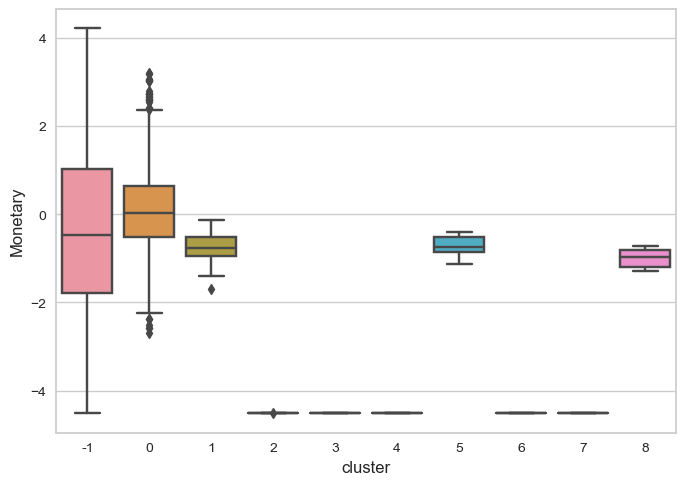

In [20]:
import seaborn as sns
sns.boxplot(x='cluster', y='Monetary', data=rfm_scaled_plot)

<Axes: xlabel='Recency', ylabel='Monetary'>

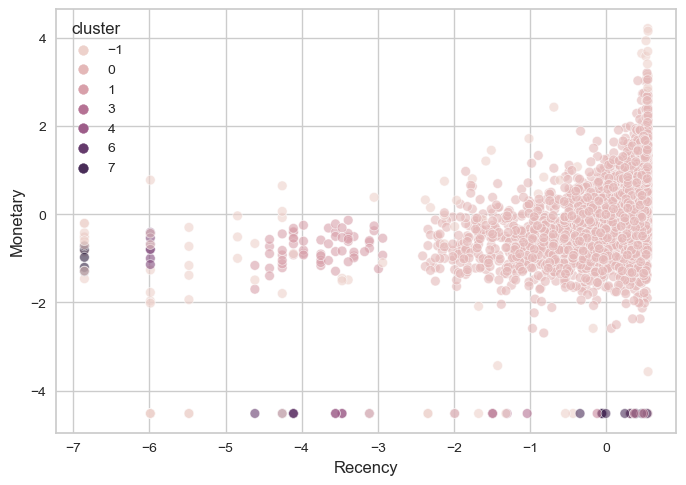

In [21]:
sns.scatterplot(data=rfm_scaled_plot, x='Recency', y='Monetary', hue='cluster', alpha=0.6)

In [22]:
import plotly.express as px
fig = px.scatter_3d(rfm_scaled_plot, x='Recency', y='Monetary', z='Frequency',
              color='cluster').update_traces(marker_size=5, marker_line=dict(width=2, color='#2F4F4F'))
fig.show()

**Cluster description by features:**

0- Most of the recent clients that have wide spectrum of Monetary and Frequency features

1- Less recent clients that have lower Frequency and Monteray upper limits

2- A few clients probably part of the 0 cluster but with close to zero Monetary and low Frequency

3- A few clients probably part of the 0 cluster but with close to zero Montetary and Frequency

4 and 6- Same as 3rd cluster but less and less recent

7- Same as the 2nd cluster but lower Frequency

5 and 8- The least recent clients that had low Monetary and Frequency

-1- Outliers (to be additionally assigned to closest cluster)

In [23]:
import plotly.express as px
fig = px.scatter_3d(rfm, x='Recency', y='Monetary', z='Frequency',
              color='cluster').update_traces(marker_size=5, marker_line=dict(width=2, color='#2F4F4F'))
fig.show()

Note:
 - Models can be trained on top of cluster labels from previous fit if you want to ensemble(transfer information).

DBSCAN is performing the best so far because it is telling us upper and lower border of each customer segment and its outliers which can be used as first step for profiling each segment.

This algorithm to be used per country.

### Countries (geospatial pre-process)

Group data in order to be plotted in interactive geospatial dashboard with Dash

In [24]:
df.Country.unique()
# Map country to customerID before aggregating by customer ID and include that in the RFM table - done
# This way we will have per country customer segmentation
# One hot encode customer_country in the pre-processing pipeline

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [25]:
# Extract country codes
df_example = px.data.gapminder().query("year==2007")
df_example.columns = ['Country', 'continent', 'year', 'lifeExp', 'pop', 'gdpPercap',
       'iso_alpha', 'iso_num']
rfm = rfm.merge(df_example[['Country', 'iso_alpha']], how='left', on='Country')
rfm

,CustomerID,Recency,Frequency,Monetary,Country,cluster,iso_alpha
0,12346.0,48,2,0.00,United Kingdom,3,GBR
1,12347.0,371,182,4310.00,Iceland,0,ISL
2,12348.0,298,31,1797.24,Finland,0,FIN
3,12349.0,355,73,1757.55,Italy,0,ITA
4,12350.0,63,17,334.40,Norway,0,NOR
...,...,...,...,...,...,...,...
4367,18280.0,96,10,180.60,United Kingdom,0,GBR
4368,18281.0,193,7,80.82,United Kingdom,0,GBR
4369,18282.0,366,13,176.60,United Kingdom,0,GBR
4370,18283.0,370,756,2094.88,United Kingdom,0,GBR


In [26]:
# Process data for geospatial plot
group = rfm.groupby("cluster")["Country"].value_counts(normalize=True)
clusterID_count = pd.DataFrame(group.values, 
                            index = group.index,
                            columns=["Percentage"]).reset_index()
geo_plot_data = clusterID_count.merge(df_example[['Country', 'iso_alpha']], how='left', on='Country')
geo_plot_data["Percentage"] = round(geo_plot_data["Percentage"] *100, 1)
geo_plot_data  # Problem: EIRE == NaN check all country/iso_alpha mappings - DONE

,cluster,Country,Percentage,iso_alpha
0,-1,United Kingdom,86.2,GBR
1,-1,EIRE,2.1,NaN
2,-1,Japan,2.1,JPN
3,-1,Netherlands,2.1,NLD
4,-1,Australia,1.1,AUS
...,...,...,...,...
61,5,Germany,12.5,DEU
62,6,United Kingdom,80.0,GBR
63,6,Germany,20.0,DEU
64,7,United Kingdom,100.0,GBR


In [27]:
# PROBLEM 14 non matching Country to iso_alpha !  (from df_example match)
geo_plot_data.isna().sum()

cluster        0
Country        0
Percentage     0
iso_alpha     14
dtype: int64

In [28]:
# Our countries not in their countries
geo_plot_data.Country.unique()[~pd.Series(geo_plot_data.Country.unique()).isin(df_example.Country.unique())]
# United States(US) = USA; (IRL) = EIRE; South Africa(ZAF) = RSA; 
# LTU == Lithuania; CYP == Cyprus; MLT == Malta; UAE == United Arab Emirates;

array(['EIRE', 'Lithuania', 'USA', 'Channel Islands', 'Cyprus',
       'Unspecified', 'Malta', 'United Arab Emirates',
       'European Community', 'RSA'], dtype=object)

In [29]:
# Fix non matching iso_alphas
list_fix = [['EIRE', 'IRL'],
            ['Lithuania', 'LTU'],
            ['USA', 'USA'],
            ['Channel Islands', 'GB-'],
            ['Cyprus', 'CYP'],
            ['Malta', 'MLT'],
            ['United Arab Emirates', 'UAE'],
            ['RSA', 'ZAF']]
for i in list_fix:
    geo_plot_data.loc[geo_plot_data.Country == i[0], 'iso_alpha'] = i[1]

In [30]:
geo_plot_data.isna().sum()  # drop "European Community" and "Unspecified" cannot be mapped by iso

cluster       0
Country       0
Percentage    0
iso_alpha     2
dtype: int64

In [31]:
# Export data for dash (geo and pie chart)
geo_plot_data.to_csv("geo_plot_data.csv")

### Feature extraction

Get most common words in df.Desctiption in order to profile each cluster we found in the previous step of the project. This will help us find customer product preferences from RFM grouping.

In [32]:
df.CustomerID.unique().shape, df.Description.unique().shape
# we have 4372 unique customers and 3896 items

((4372,), (3896,))

In [33]:
items = df.Description.unique()
items

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### Complex method (DRAFT)

Using NLP to pre-process and cluster most common words for cluster segmentation. Exclude stop-words, and keep only nouns.

In [34]:
# %pip install spacy
# !python -m spacy download en_core_web_sm

In [35]:
import spacy
import numpy as np
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

def process_sentence(sentence):
    doc = nlp(sentence.lower())
    # Remove stop words, non-alphabetic words and perform lemmatization
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.pos_ == 'NOUN']
    return tokens

def create_noun_vectors(nouns):
    noun_vectors = [nlp(noun).vector for noun in nouns]
    return noun_vectors

def visualize_dendrogram(noun_vectors):
    # Perform hierarchical clustering and plot the dendrogram
    Z = linkage(noun_vectors, method='average', metric='cosine')
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
    plt.show()

def cluster_sentences(sentences):
    all_nouns = set()
    sentence_nouns = []
    for sentence in sentences:
        nouns = process_sentence(sentence)
        sentence_nouns.append(nouns)
        all_nouns.update(nouns)

    noun_vectors = create_noun_vectors(all_nouns)
    visualize_dendrogram(noun_vectors)

    # Manually set parameter value
    distance_threshold = float(input("Enter the distance threshold: "))

    # Perform Agglomerative Clustering with the specified distance threshold
    clustering = AgglomerativeClustering(n_clusters=None, 
                                         affinity='cosine', linkage='average', 
                                         distance_threshold=distance_threshold)
    noun_cluster_labels = clustering.fit_predict(noun_vectors)

    # Create a dictionary mapping each noun to its cluster label
    noun_to_cluster = {noun: label for noun, label in zip(all_nouns, noun_cluster_labels)}

    # Assign each sentence to the cluster of its most common noun
    sentence_clusters = {}
    for sentence, nouns in zip(sentences, sentence_nouns):
        if nouns:
            most_common_noun = Counter(nouns).most_common(1)[0][0]
            cluster_label = noun_to_cluster[most_common_noun]
            if cluster_label not in sentence_clusters:
                sentence_clusters[cluster_label] = []
            sentence_clusters[cluster_label].append(sentence)

    # Find the most common noun for each cluster and rename the cluster
    cluster_to_name = {}
    for cluster_label, items in sentence_clusters.items():
        noun_counter = Counter()
        for item in items:
            tokens = process_sentence(item)
            noun_counter.update(tokens)
        most_common_noun = noun_counter.most_common(1)[0][0] if noun_counter else "NoNoun"
        cluster_to_name[cluster_label] = most_common_noun

    # Create a 2D numpy array with sentences and their cluster names
    sentence_cluster_array = np.array([[sentence, cluster_to_name[noun_to_cluster[Counter(nouns).most_common(1)[0][0]]]] for sentence, nouns in zip(sentences, sentence_nouns) if nouns])

    return sentence_cluster_array

In [36]:
process_sentence(items[0])  # split and lemmatized forms of all noun words in the sentence

['heart', 't', 'light', 'holder']

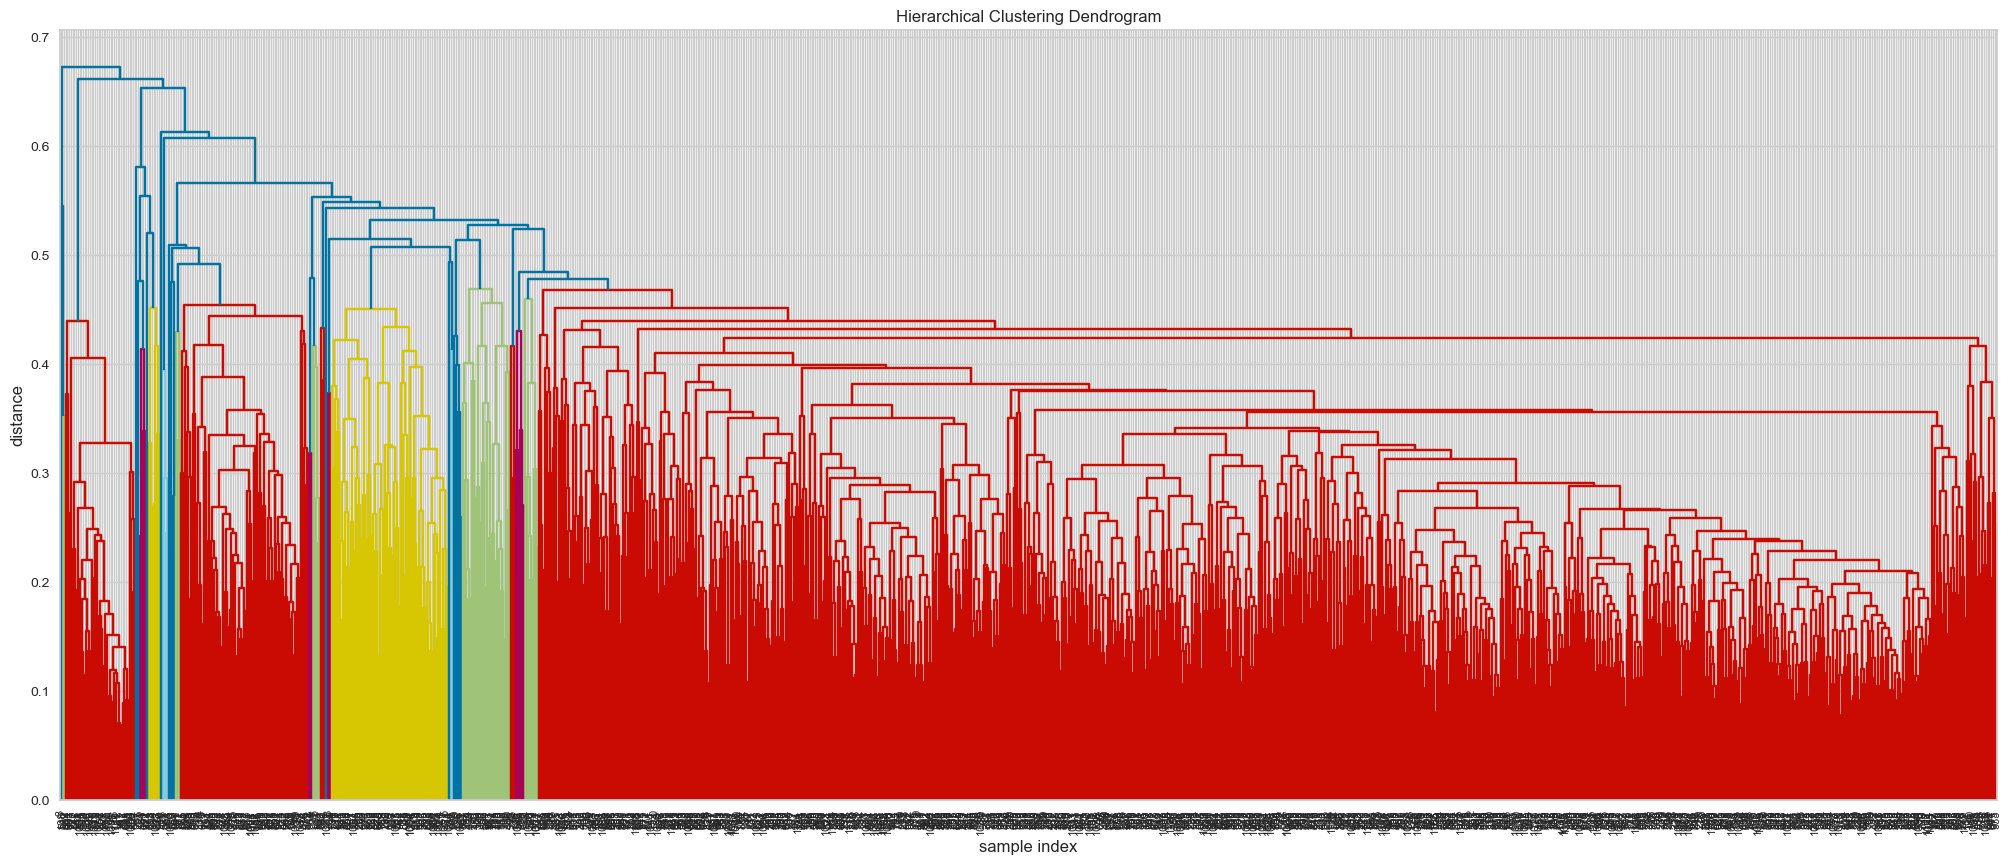

array([['WHITE HANGING HEART T-LIGHT HOLDER', 'heart'],
       ['WHITE METAL LANTERN', 'metal'],
       ['CREAM CUPID HEARTS COAT HANGER', 'cream'],
       ...,
       ['PINK CRYSTAL SKULL PHONE CHARM', 'crystal'],
       ['CREAM HANGING HEART T-LIGHT HOLDER', 'cream'],
       ['PAPER CRAFT , LITTLE BIRDIE', 'paper']], dtype='<U35')

In [37]:
results_array = cluster_sentences(items)
results_array

Results:
- found out most common nouns in each item description and formed clusters based on agglomerativeclustering algorithm with manually set distance_threshold parameter based on visualisation dendrogram
- generate 2d array with mapped clusters to each item description
- to be used in the customer profile part of the project

Notes:
- many approaches could have been used but most common nouns in a sentence represent the actual product and it is more generalizing than specific item features like colors, which will produce many small clusters

To do:
- map item description clusters to df and analyze before aggregating to rfm

Problem:
- we need to profile clusters not every customer

In [38]:
cluster_words = pd.DataFrame(results_array, columns=['Description', 'cluster_agg'])
cluster_words

,Description,cluster_agg
0,WHITE HANGING HEART T-LIGHT HOLDER,heart
1,WHITE METAL LANTERN,metal
2,CREAM CUPID HEARTS COAT HANGER,cream
3,KNITTED UNION FLAG HOT WATER BOTTLE,flag
4,RED WOOLLY HOTTIE WHITE HEART.,heart
...,...,...
3630,"LETTER ""W"" BLING KEY RING",letter
3631,"LETTER ""Z"" BLING KEY RING",letter
3632,PINK CRYSTAL SKULL PHONE CHARM,crystal
3633,CREAM HANGING HEART T-LIGHT HOLDER,cream


In [39]:
# Export nlp data
cluster_words.to_csv('complex_nlp_clusters.csv')

In [40]:
merge_complex = df.merge(cluster_words, how='left', on='Description')
merge_complex.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff,cluster_agg
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,heart
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,metal
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,cream


#### Simpler method (ACTUAL)
Just counting tokens without nlp pre-processing

In [41]:
# INFO Find total most common tokens without nlp processing
from sklearn.feature_extraction.text import CountVectorizer
n = 30
item_tokens = pd.DataFrame([i.lower().split() for i in items])
flatten_df = item_tokens.to_numpy().flatten()
flatten_df = flatten_df[flatten_df != np.array(None)]  # drop None

vectorizer = CountVectorizer()
z = vectorizer.fit_transform(flatten_df)

word_counter = pd.DataFrame([z.toarray().sum(axis=0), vectorizer.get_feature_names_out()]).T
word_counter.columns = ['count', 'common_words']
word_counter['count'] = word_counter['count'].astype(int)
most_common_words = word_counter.nlargest(n, 'count').reset_index(drop=True)
most_common_words.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,337,313,238,237,228,216,201,165,163,148,...,100,99,99,99,97,97,96,94,90,85
common_words,set,pink,of,heart,blue,vintage,red,bag,glass,christmas,...,black,decoration,green,rose,candle,wall,retrospot,silver,necklace,cake


In [42]:
## INFO: Find total most common words with nlp processing
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

A = items

def process_sentence(sentence):
    doc = nlp(sentence.lower())
    # Remove stop words, non-alphabetic words and perform lemmatization
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.pos_ == 'NOUN']
    return tokens

def process(sentences):
    sentence_nouns = []
    for sentence in sentences:
        nouns = process_sentence(sentence)
        sentence_nouns.extend(nouns)
    return sentence_nouns


X = process(A)
vectorizer = CountVectorizer()
z = vectorizer.fit_transform(X)

word_counter = pd.DataFrame([z.toarray().sum(axis=0), vectorizer.get_feature_names_out()]).T
word_counter.columns = ['count', 'common_words']
word_counter['count'] = word_counter['count'].astype(int)
most_common_words_nlp = word_counter.nlargest(n, 'count').reset_index(drop=True)
most_common_words_nlp.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,248,141,126,119,119,117,113,109,108,107,...,57,56,55,53,52,51,49,47,46,46
common_words,heart,light,candle,glass,holder,bag,flower,metal,design,decoration,...,tin,retrospot,egg,gift,necklace,cushion,pack,earring,bowl,tree


In [43]:
# Assign RFM cluster_id to df
df = df.merge(rfm[['CustomerID', 'cluster']], how='left', on='CustomerID')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,0,-1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,-1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,0,-1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,-1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,0,-1


In [44]:
# Create function for dashboards to merge common words per cluster per country
def get_most_common(filtered, n=5):
    '''Takes filtered df by cluster by country,
    reads items and counts most common words,
    returns list of n largest words per filter.
    '''
    item_tokens = pd.DataFrame([i.lower().split() for i in filtered])
    flatten_df = item_tokens.to_numpy().flatten()
    flatten_df = flatten_df[flatten_df != np.array(None)]  # drop None

    vectorizer = CountVectorizer()
    z = vectorizer.fit_transform(flatten_df)

    word_counter = pd.DataFrame([z.toarray().sum(axis=0), vectorizer.get_feature_names_out()]).T
    word_counter.columns = ['count', 'common_words']
    word_counter['count'] = word_counter['count'].astype(int)
    most_common_words = word_counter.nlargest(n, 'count').reset_index(drop=True)
    return list(most_common_words.common_words)

In [45]:
# Create mapping table with most common words
clusters = df.cluster.unique()
countries = df.Country.unique()

collect = []
for i, j in product(clusters, countries):
    try:
        filtered = df[(df.cluster == i)&(df.Country == j)].Description
        common_words_list = get_most_common(filtered, n=5)
        collect.append([i, j, common_words_list])
    except:
        None

In [46]:
most_common_map = pd.DataFrame(collect, columns=['cluster', 'Country', 'most_common_words'])  # to be assigned to RFM and used in dashboards as additional data 
most_common_map

,cluster,Country,most_common_words
0,-1,United Kingdom,"[set, bag, of, red, heart]"
1,-1,France,"[dolly, girl, jigsaw, mini, and]"
2,-1,Australia,"[set, of, vintage, red, retrospot]"
3,-1,Netherlands,"[set, bag, of, red, retrospot]"
4,-1,Germany,"[retrospot, set, red, of, paper]"
...,...,...,...
61,3,United Kingdom,"[ceramic, cake, cakes, hanging, jar]"
62,3,Italy,[manual]
63,2,United Kingdom,"[set, of, drawer, knob, ceramic]"
64,2,Spain,"[box, chandelier, white, holder, light]"


In [47]:
# Merge most_common_words and export
geo_plot_data = geo_plot_data.merge(most_common_map, how='left', on=['cluster', 'Country'])
geo_plot_data.to_csv('geo_plot_data.csv')  # dashboards data

#### Density plots (additional analysis)

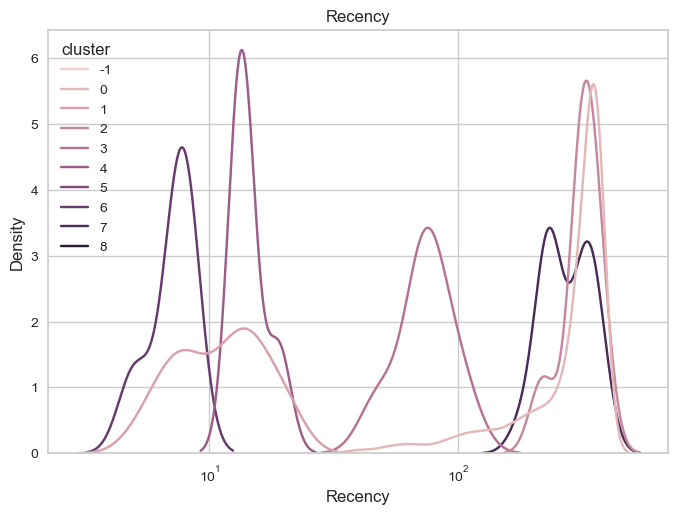

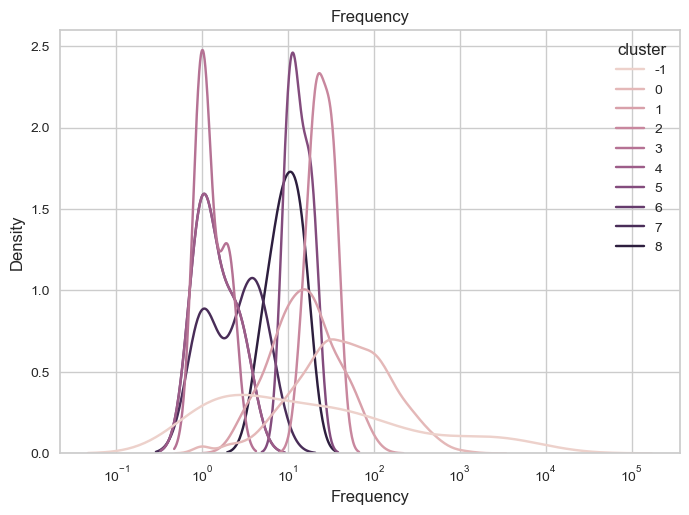

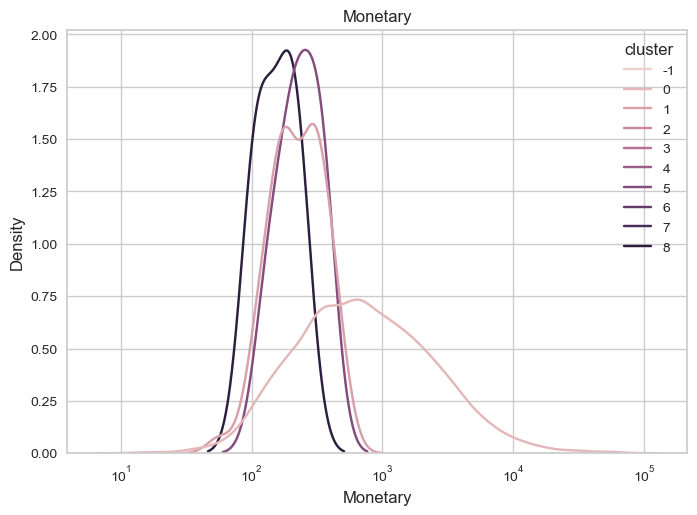

In [48]:
# Density plots (cluster distributions by feature)
plot_data = rfm  #[(rfm.cluster == 0)|(rfm.cluster == 1)]
features_list = ['Recency', 'Frequency', 'Monetary']
for i in features_list:
    plt.figure()
    plt.title(i)
    sns.kdeplot(data=plot_data, x=i, hue='cluster', log_scale=True, common_norm=False)